In [21]:
import torch, torchvision
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [22]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="data/",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="data/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=4)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [36]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()
        # First convolution
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=int(in_channels/2),
                                     kernel_size=1)
        self.bn1 = nn.BatchNorm2d(int(in_channels/2))

        # Second convolution: Depthwise, seperable convolution with a large number of output filters:
        self.conv2 = nn.Conv2d(in_channels=int(in_channels/2),
                                     out_channels=int(in_channels/2),
                                     groups=int(in_channels/2),
                                     kernel_size=[3,3],
                                     padding='same' )
        self.dropout = nn.Dropout2d(p=0.2)
        self.bn2 = nn.BatchNorm2d(int(in_channels/2))

        # Last convolution:
        self.conv3 = nn.Conv2d(in_channels=int(in_channels/2),
                                     out_channels=in_channels,
                                     kernel_size=1)
        self.bn3 = nn.BatchNorm2d(in_channels)






    def forward(self, inputs):

        # First Conv
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = torch.nn.functional.gelu(x)

        # Second Conv
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.bn2(x)
        x = torch.nn.functional.gelu(x)

        # Third Conv
        x = self.conv3(x)
        x = self.bn3(x)


        # This makes it a residual network:
        return torch.nn.functional.gelu(x + inputs)


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [34]:
int(4/2)

2

In [27]:
! pip install torchinfo

In [37]:
model = Classifier(64, 4, 2)

model.to(dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         2,080
│    │    └─BatchNorm2d: 3-2             [128, 32, 32, 32]         64
│    │    └─Conv2d: 3-3                  [128, 32, 32, 32]         320
│    │    └─Dropout2d: 3-4               [128, 32, 32, 32]         --
│    │    └─BatchNorm2d: 3-5             [128, 32, 32, 32]         64
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         2,112
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         128
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│

In [38]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [39]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [40]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [41]:
from tqdm.notebook import tqdm
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_losses.append(loss)
        train_accs.append(acc)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        val_losses.append(loss_val)
        val_accs.append(acc_val)


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.463, accuracy: 46.131


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.475, accuracy: 46.114


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.117, accuracy: 59.328


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.135, accuracy: 58.752


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 0.927, accuracy: 67.040


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.962, accuracy: 65.348


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 0.820, accuracy: 71.458


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.868, accuracy: 68.651


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.685, accuracy: 75.879


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.743, accuracy: 73.111


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.624, accuracy: 78.010


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.702, accuracy: 74.901


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.566, accuracy: 79.980


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.648, accuracy: 76.414


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.538, accuracy: 80.826


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.639, accuracy: 76.711


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.476, accuracy: 83.446


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.588, accuracy: 78.560


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.508, accuracy: 81.869


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.619, accuracy: 77.917


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.426, accuracy: 85.179


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.557, accuracy: 80.350


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.400, accuracy: 86.135


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.546, accuracy: 80.261


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.372, accuracy: 86.961


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.512, accuracy: 81.359


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.354, accuracy: 87.700


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.521, accuracy: 81.171


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.383, accuracy: 86.217


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.554, accuracy: 80.518


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.314, accuracy: 89.020


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.491, accuracy: 82.496


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.307, accuracy: 89.197


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.510, accuracy: 81.972


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.281, accuracy: 90.146


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.482, accuracy: 82.921


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.261, accuracy: 90.742


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.479, accuracy: 82.694


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.257, accuracy: 90.885


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.479, accuracy: 83.495


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.251, accuracy: 91.122


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.473, accuracy: 83.000


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.252, accuracy: 91.024


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.491, accuracy: 83.010


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.227, accuracy: 92.005


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.469, accuracy: 83.722


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.206, accuracy: 92.904


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.449, accuracy: 84.395


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.198, accuracy: 92.954


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.478, accuracy: 83.811


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.181, accuracy: 93.510


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.458, accuracy: 84.523


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.196, accuracy: 93.014


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.479, accuracy: 83.970


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.174, accuracy: 93.985


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.473, accuracy: 84.009


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.175, accuracy: 93.780


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.474, accuracy: 84.039


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.165, accuracy: 94.137


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.471, accuracy: 84.335


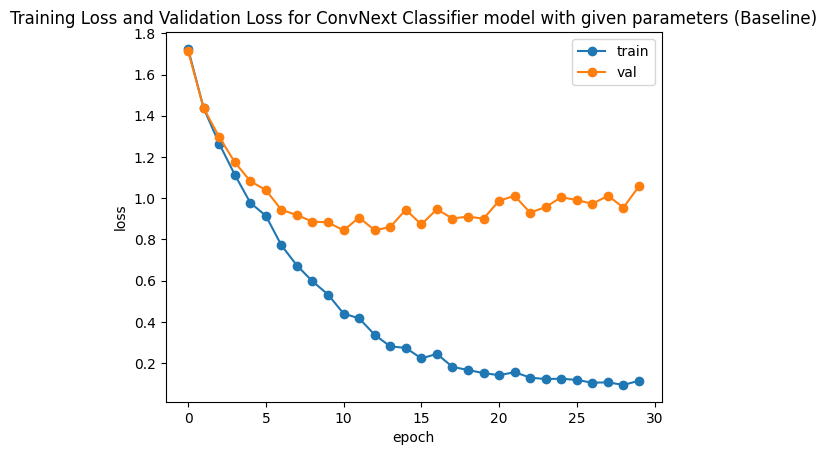

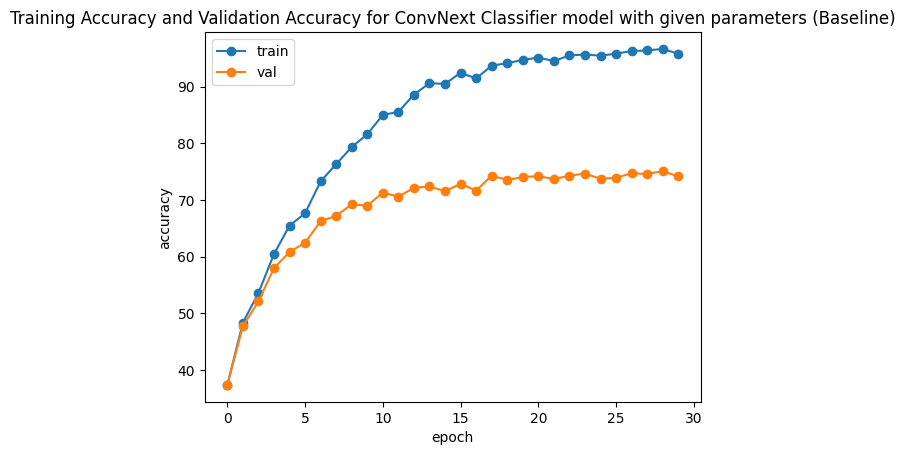

In [20]:
btrain_loss_x = np.arange(0,len(train_losses))
train_loss_y = np.asarray(train_losses)
val_loss_x = np.arange(0,len(val_losses))
val_loss_y = np.asarray(val_losses)
plt.plot(train_loss_x,train_loss_y, 'o-')
plt.plot(val_loss_x,val_loss_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training Loss and Validation Loss for ConvNext Classifier model with given parameters (Baseline)')
plt.show()
train_acc_x = np.arange(0,len(train_accs))
train_acc_y = np.asarray(train_accs)
val_acc_x = np.arange(0,len(val_accs))
val_acc_y = np.asarray(val_accs)
plt.plot(train_acc_x,train_acc_y, 'o-')
plt.plot(val_acc_x,val_acc_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy and Validation Accuracy for ConvNext Classifier model with given parameters (Baseline)')
plt.show()

Even though the baseline model has a reasonable performance with a peak validation accuracy of about 75%, it is clear from the loss that after epoch 10 overfitting is happening. Also, the training and validation metrics differ quite a bit and the design of the ResNeXt block is not to my liking as there is a 7x7 kernel convolution followed by a LayerNormalization (LN) and then by two 1x1 kernel convolutions with an activation function (Act) in between:

*   7x7 Conv
*   LN
*   1x1 Conv
*   Act
*   1x1 Conv
*   Residual Concatenation


Therefore, I changed the ResNeXt block structure to be a 1x1 kernel convolution followed by BatchNormalization (BN) and Activation function (Act) followed by a 3x3 kernel convolution + Dropout (20%) + BN + Act and lastly a 1x1 kernel convolution + BN and the results of that concatenated with the input and through the activation function.

*   1x1 Conv
*   BN
*   Act
*   3x3 Conv
*   Dropout
*   BN
*   Act
*   1x1 Conv
*   BN
*   Residual Concatenation
*   Act

The reason for these changes are that for a 32x32 image a 7x7 kernel is absolute overkill. Further I added a dropout after the 3x3 convolution in hope of producing less overfitting. Also it is usually good practice to have a convolution followed by a batch normalization and activation function. Additionally is in my opinion the benefit of the 1x1 kernel convolutions the highest if it used to reduce some dimensions of the data and therefore I reduced the channels after the first 1x1 convolution to the half and the last 1x1 convolution increases it back to the original size. Lastly, I used the last activation function after the concatenation. All of this leads to a much smaller model with only 1.7M params instead of 7.2M

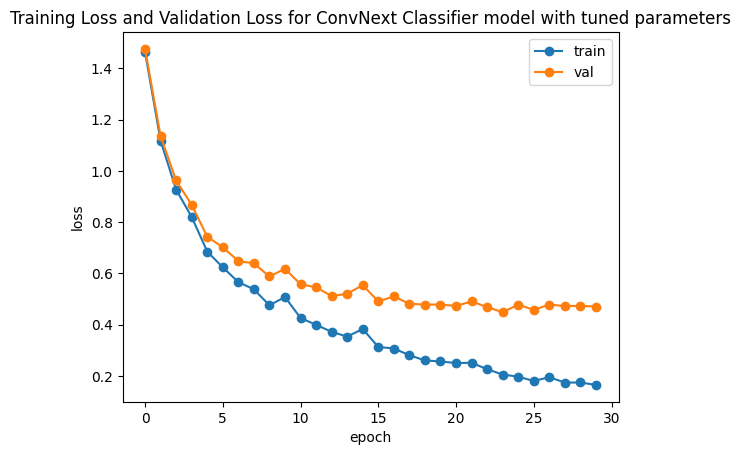

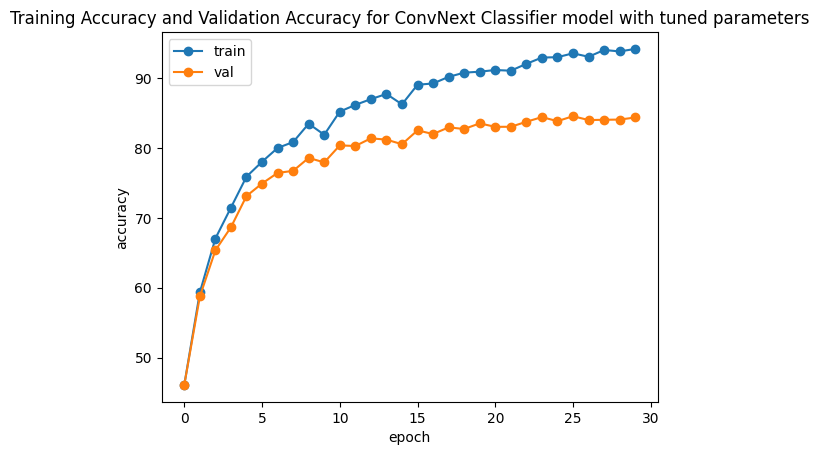

In [42]:
train_loss_x = np.arange(0,len(train_losses))
train_loss_y = np.asarray(train_losses)
val_loss_x = np.arange(0,len(val_losses))
val_loss_y = np.asarray(val_losses)
plt.plot(train_loss_x,train_loss_y, 'o-')
plt.plot(val_loss_x,val_loss_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training Loss and Validation Loss for ConvNext Classifier model with tuned parameters')
plt.show()
train_acc_x = np.arange(0,len(train_accs))
train_acc_y = np.asarray(train_accs)
val_acc_x = np.arange(0,len(val_accs))
val_acc_y = np.asarray(val_accs)
plt.plot(train_acc_x,train_acc_y, 'o-')
plt.plot(val_acc_x,val_acc_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy and Validation Accuracy for ConvNext Classifier model with tuned parameters')
plt.show()

So with the above explained changes the computation time was reduced and there seems to be much less overfitting and the validation metrics are much closer to the training metrics. The best validation accuracy is with 84.5% approximately 10% higer than before and the best validation loss is 0.449 at epoch 23 instead of 0.872 at epoch 10.